In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import os
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold


import matplotlib.pyplot as plt

2024-05-12 11:19:18.636508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 11:19:18.636609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 11:19:18.769346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import gc 
gc.collect()

0

In [6]:
train_df_chunk = pd.read_csv('/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv', chunksize=500000)

In [7]:
train_df_chunk

In [8]:
# Initialize chunk_1 to None
chunk_1 = None

# Loop over chunks and break after the first
for chunk in train_df_chunk:
    chunk_1 = chunk  # Assign the first chunk to chunk_1
    break  # Exit the loop after assigning the first chunk

In [10]:
chunk_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 925 entries, sample_id to cam_out_SOLLD
dtypes: float64(924), object(1)
memory usage: 3.4+ GB


In [11]:
# #storing the chunks after iterating from chunk object
# chunk_data=[chunk for chunk in train_df_chunk]

# #concatnating dataframes to make it a complete dataset
# train=pd.concat(chunk_data)

In [12]:
chunk_1.head()

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,train_0,213.806117,222.244454,229.259879,245.743959,258.337482,265.772467,263.978456,254.879872,243.946147,...,-6.132147e-07,1.401824e-06,0.0,349.564325,0.0,2.947672e-12,0.0,0.0,0.0,0.0
1,train_1,213.177430,225.851064,229.663618,246.828333,261.026415,269.078431,267.736565,256.896227,244.169421,...,3.560950e-07,9.984912e-07,0.0,335.204086,0.0,3.138366e-09,0.0,0.0,0.0,0.0
2,train_2,217.105685,220.448106,234.653398,244.422951,254.023818,259.651472,257.709514,251.064513,241.879600,...,1.565672e-06,6.186607e-05,0.0,401.709340,0.0,7.424215e-09,0.0,0.0,0.0,0.0
3,train_3,217.773994,225.611775,234.104091,247.745365,257.411402,263.470947,261.131775,253.303250,242.316814,...,-9.067304e-06,1.020519e-05,0.0,400.230177,0.0,2.534090e-08,0.0,0.0,0.0,0.0
4,train_4,216.349337,230.526083,233.650252,248.196013,262.500730,270.055663,268.863606,258.161645,244.442620,...,1.681596e-06,-6.378779e-06,0.0,321.960470,0.0,3.377415e-10,0.0,0.0,0.0,0.0


In [13]:
chunk_1.describe

<bound method NDFrame.describe of            sample_id   state_t_0   state_t_1   state_t_2   state_t_3  \
0            train_0  213.806117  222.244454  229.259879  245.743959   
1            train_1  213.177430  225.851064  229.663618  246.828333   
2            train_2  217.105685  220.448106  234.653398  244.422951   
3            train_3  217.773994  225.611775  234.104091  247.745365   
4            train_4  216.349337  230.526083  233.650252  248.196013   
...              ...         ...         ...         ...         ...   
499995  train_499995  215.314927  235.136866  240.494145  244.856329   
499996  train_499996  214.835395  233.027804  237.441561  243.022841   
499997  train_499997  213.401786  226.846125  231.639625  243.094895   
499998  train_499998  213.989370  232.394946  236.755119  245.010569   
499999  train_499999  212.377710  223.761567  231.827592  245.639691   

         state_t_4   state_t_5   state_t_6   state_t_7   state_t_8  ...  \
0       258.337482  265.77

In [14]:
FEAT_COLS = chunk_1.columns[1:557]
TARGET_COLS = chunk_1.columns[557:]
print(f'Number of features: {len(FEAT_COLS)}')
print(f'Number of targets: {len(TARGET_COLS)}')

Number of features: 556
Number of targets: 368


In [15]:
# Custom R² metric
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + K.epsilon())
    return r2

# Create a simple neural network for multi-output regression
def build_regression_model(input_shape, output_shape):
    model = keras.Sequential([
        layers.Dense(2048, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(output_shape[0]),  # Output layer for multi-output regression
    ])
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',  # Loss function for regression
        metrics=[r2_metric]  # Using R² as an evaluation metric
    )
    return model


In [17]:
num_epochs = 50  # Number of epochs to train
batch_size = 64  # Batch size for training
input_shape = (556,)  # Number of input features
output_shape = (368,)  # Number of target columns

# Build the regression model
model = build_regression_model(input_shape, output_shape)

# To collect training history
training_history = []

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 2048)           │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 368)            │        47,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,413,296 (9.21 MB)

 Trainable params: 2,407,408 (9.18 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [18]:
history = model.fit(
    chunk_1.iloc[:, 1:557],  # Features
    chunk_1.iloc[:, 557:],    # Labels
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1
)

# Convert the training history to a DataFrame
training_history = {
    "epoch": list(range(1, num_epochs + 1)),
    "loss": history.history["loss"],
    "r2": history.history["r2_metric"]
}
training_df = pd.DataFrame(training_history)

Epoch 1/50
  59/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 673.8312 - r2_metric: 0.0061   

I0000 00:00:1715513067.322599     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715513067.344714     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 207.1585 - r2_metric: 0.6964
Epoch 2/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 40.1345 - r2_metric: 0.9406
Epoch 3/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 38.7822 - r2_metric: 0.9428
Epoch 4/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 40.2126 - r2_metric: 0.9406
Epoch 5/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 39.1373 - r2_metric: 0.9419
Epoch 6/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 39.4379 - r2_metric: 0.9417
Epoch 7/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 38.2775 - r2_metric: 0.9435
Epoch 8/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 39.0098 - r2_metric: 0.9424
Epoch 9/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 40.6226 - r2_metric: 0.9399
Epoch 10/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 39.3546 - r2_metric: 0.9418
Epoch 11/50
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 38.7393 - r2_metric: 0.9427
Epoch 1

In [19]:
# for epoch in range(num_epochs):
#     print(f"Training epoch {epoch + 1}/{num_epochs}")

#     # Loop over each chunk and train the model
#     for i, chunk in enumerate(train_df_chunk):
#         # Extract features and labels from the chunk
#         features = chunk.iloc[:,1:557]  # First 556 columns as features less sample_id
#         labels = chunk.iloc[:, 557:]  # Remaining 368 columns as targets
        
#         # Train the model on this chunk and collect history
#         history = model.fit(
#             features,
#             labels,
#             epochs=5,  # Train one epoch for each chunk
#             batch_size=batch_size,
#             verbose=1  # Change to 0 to suppress output
#         )
        
#         # Store the history
#         epoch_history = {
#             "epoch": epoch + 1,
#             "chunk": i + 1,
#             "loss": history.history["loss"][0],
#             "r2": history.history["r2_metric"][0]
#         }
        
#         training_history.append(epoch_history)

# # Convert the training history to a DataFrame
# training_df = pd.DataFrame(training_history)

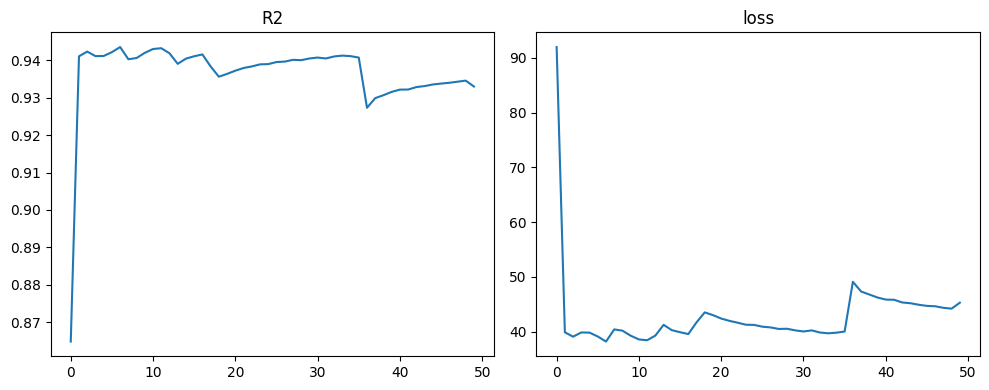

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 'column1' in the first subplot
ax1.plot(training_df['r2'])
ax1.set_title('R2')

# Plot 'column2' in the second subplot
ax2.plot(training_df['loss'])
ax2.set_title('loss')

# Display the plots
plt.tight_layout()
plt.show()

In [21]:
# Test dataset and sample prediction file paths
test_file_path = '/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv'  # Path to the test dataset
sample_prediction_file_path = '/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv'  # Path to the sample prediction file

# Define the chunksize for reading the test and sample datasets
chunksize = 50000  # Chunk size for processing

# Open the file in write mode to store predictions
prediction_file_path = 'final_submission.csv'


# Read both test and sample prediction data in chunks
test_df_chunk = pd.read_csv(test_file_path, chunksize=chunksize)
sample_prediction_chunk = pd.read_csv(sample_prediction_file_path, chunksize=chunksize)

In [22]:
# Initialize test_chunk_1 to None
test_chunk_1 = None

# Loop over chunks and break after the first
for chunk in test_df_chunk:
    test_chunk_1 = chunk  # Assign the first chunk to test_chunk_1
    break  # Exit the loop after assigning the first chunk
    
test_chunk_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 557 entries, sample_id to pbuf_N2O_59
dtypes: float64(556), object(1)
memory usage: 212.5+ MB


In [23]:
# Initialize sample_chunk_1 to None
sample_chunk_1 = None

# Loop over chunks and break after the first
for chunk in sample_prediction_chunk:
    sample_chunk_1 = chunk  # Assign the first chunk to sample_chunk_1
    break  # Exit the loop after assigning the first chunk
    
sample_chunk_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 369 entries, sample_id to cam_out_SOLLD
dtypes: float64(305), int64(63), object(1)
memory usage: 140.8+ MB


In [24]:
# Read both test and sample prediction data in chunks
test_df = pd.read_csv(test_file_path)
sample_prediction = pd.read_csv(sample_prediction_file_path)

In [25]:
test_df.shape

(625000, 557)

In [26]:
sample_prediction.shape

(625000, 369)

In [27]:
prediction = model.predict(test_df.iloc[:, 1:557])
prediction.shape

19532/19532 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


(625000, 368)

In [28]:
sample_prediction.drop(['sample_id'], axis=1).to_numpy()

array([[3.09812653e+04, 2.25024324e+04, 1.88941471e+04, ...,
        8.58988517e-03, 2.15368189e-02, 3.36321309e-02],
       [3.09812653e+04, 2.25024324e+04, 1.88941471e+04, ...,
        8.58988517e-03, 2.15368189e-02, 3.36321309e-02],
       [3.09812653e+04, 2.25024324e+04, 1.88941471e+04, ...,
        8.58988517e-03, 2.15368189e-02, 3.36321309e-02],
       ...,
       [3.09812653e+04, 2.25024324e+04, 1.88941471e+04, ...,
        8.58988517e-03, 2.15368189e-02, 3.36321309e-02],
       [3.09812653e+04, 2.25024324e+04, 1.88941471e+04, ...,
        8.58988517e-03, 2.15368189e-02, 3.36321309e-02],
       [3.09812653e+04, 2.25024324e+04, 1.88941471e+04, ...,
        8.58988517e-03, 2.15368189e-02, 3.36321309e-02]])

In [29]:
multiplied_predictions = np.multiply(prediction,sample_prediction.drop(['sample_id'], axis=1).to_numpy())
multiplied_predictions

array([[ 1.24115694e-01,  3.16290437e+02, -5.88118791e+01, ...,
         1.29741487e-02,  1.27164579e-01,  9.56345886e-02],
       [ 1.15576959e-01,  3.21043637e+02, -5.72250578e+01, ...,
         1.54230921e-02,  1.25562702e-01,  9.17712152e-02],
       [ 1.54611982e-01,  3.10448415e+02, -5.85659585e+01, ...,
         1.25534510e-02,  1.25795688e-01,  9.69993094e-02],
       ...,
       [-1.44048269e+00,  3.05227046e+01, -2.43639199e+01, ...,
         1.56615770e-01,  2.16891267e-02,  3.86059577e-02],
       [-2.44513383e+00,  3.24811758e+00, -1.47624417e+01, ...,
         1.49994723e-01, -1.41424904e-01, -6.43806399e-02],
       [-1.05170294e-01,  2.23776559e+02, -5.46074396e+01, ...,
         5.62356224e-02,  1.76385264e-01,  1.56745563e-01]])

In [30]:
(sample_prediction.iloc[:, 0] == test_df.iloc[:, 0]).sum()

625000

In [31]:
predictions_df = pd.DataFrame(multiplied_predictions)
column_names = sample_prediction.columns[1:]
predictions_df.columns = column_names
predictions_df

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,0.124116,316.290437,-58.811879,136.345576,6.870074,-212.536377,-6.206346,-6.694757,-92.455810,-90.731612,...,5.622753,-0.393593,0.049994,5.913401,-30620.012144,-88297.551657,0.011131,0.012974,0.127165,0.095635
1,0.115577,321.043637,-57.225058,170.284403,0.676785,-204.726808,-6.239409,-5.999341,-95.887013,-83.598797,...,9.092978,-0.378931,0.050133,5.846879,-25184.390815,-100145.362184,0.013914,0.015423,0.125563,0.091771
2,0.154612,310.448415,-58.565959,122.946301,6.598998,-212.359575,-6.170559,-6.912840,-92.219432,-93.071200,...,5.727491,-0.238873,0.050356,5.908141,-33973.791519,-83060.826517,0.010788,0.012553,0.125796,0.096999
3,0.166016,308.156136,-58.592609,116.278606,6.990656,-212.788013,-6.153939,-7.024547,-91.849764,-94.368649,...,5.454461,-0.187993,0.050330,5.909706,-35510.374732,-80305.169610,0.010361,0.012151,0.125454,0.097756
4,0.105418,324.474259,-56.371476,190.430517,-2.415157,-199.276498,-6.233061,-5.539222,-96.689397,-78.302904,...,10.322595,-0.349994,0.050255,5.790398,-22328.975507,-105590.054559,0.015201,0.016597,0.126612,0.091615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624995,-2.090651,-18.241759,-4.100825,351.180215,-196.452335,63.096995,-1.772536,-4.242607,11.116826,-212.409096,...,126.365826,2.825810,0.180105,2.807353,5674.031432,-212500.110412,0.141179,0.222120,0.001223,0.061326
624996,-1.906710,-20.610113,-2.953759,329.060676,-189.012282,68.284947,-1.515416,-3.720251,18.058137,-206.037244,...,120.850725,2.724000,0.199349,2.773293,9083.703721,-207576.929394,0.153272,0.238852,0.049490,0.100310
624997,-1.440483,30.522705,-24.363920,-52.457989,-111.250117,-37.218398,-3.294311,-21.962867,-51.090485,-156.865411,...,117.216198,0.843946,0.126225,4.173943,-71942.667930,-134237.615151,0.110974,0.156616,0.021689,0.038606
624998,-2.445134,3.248118,-14.762442,260.776687,-190.512263,1.614876,-3.202880,-13.805037,-44.604025,-223.033491,...,133.413246,2.328786,0.093108,3.437985,-55913.974623,-173680.398246,0.095228,0.149995,-0.141425,-0.064381


In [32]:
# Add the `target_id` column from the test data
predictions_df['sample_id'] = sample_prediction.iloc[:, 0]
predictions_df

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD,sample_id
0,0.124116,316.290437,-58.811879,136.345576,6.870074,-212.536377,-6.206346,-6.694757,-92.455810,-90.731612,...,-0.393593,0.049994,5.913401,-30620.012144,-88297.551657,0.011131,0.012974,0.127165,0.095635,test_169651
1,0.115577,321.043637,-57.225058,170.284403,0.676785,-204.726808,-6.239409,-5.999341,-95.887013,-83.598797,...,-0.378931,0.050133,5.846879,-25184.390815,-100145.362184,0.013914,0.015423,0.125563,0.091771,test_524862
2,0.154612,310.448415,-58.565959,122.946301,6.598998,-212.359575,-6.170559,-6.912840,-92.219432,-93.071200,...,-0.238873,0.050356,5.908141,-33973.791519,-83060.826517,0.010788,0.012553,0.125796,0.096999,test_634129
3,0.166016,308.156136,-58.592609,116.278606,6.990656,-212.788013,-6.153939,-7.024547,-91.849764,-94.368649,...,-0.187993,0.050330,5.909706,-35510.374732,-80305.169610,0.010361,0.012151,0.125454,0.097756,test_403572
4,0.105418,324.474259,-56.371476,190.430517,-2.415157,-199.276498,-6.233061,-5.539222,-96.689397,-78.302904,...,-0.349994,0.050255,5.790398,-22328.975507,-105590.054559,0.015201,0.016597,0.126612,0.091615,test_484578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624995,-2.090651,-18.241759,-4.100825,351.180215,-196.452335,63.096995,-1.772536,-4.242607,11.116826,-212.409096,...,2.825810,0.180105,2.807353,5674.031432,-212500.110412,0.141179,0.222120,0.001223,0.061326,test_578220
624996,-1.906710,-20.610113,-2.953759,329.060676,-189.012282,68.284947,-1.515416,-3.720251,18.058137,-206.037244,...,2.724000,0.199349,2.773293,9083.703721,-207576.929394,0.153272,0.238852,0.049490,0.100310,test_395695
624997,-1.440483,30.522705,-24.363920,-52.457989,-111.250117,-37.218398,-3.294311,-21.962867,-51.090485,-156.865411,...,0.843946,0.126225,4.173943,-71942.667930,-134237.615151,0.110974,0.156616,0.021689,0.038606,test_88942
624998,-2.445134,3.248118,-14.762442,260.776687,-190.512263,1.614876,-3.202880,-13.805037,-44.604025,-223.033491,...,2.328786,0.093108,3.437985,-55913.974623,-173680.398246,0.095228,0.149995,-0.141425,-0.064381,test_79382


In [33]:
# Write the predictions to the CSV file, append with index=False
predictions_df.to_csv(prediction_file_path, index=False)